This Jupyter Notebook will use data sourced from datacamp.com to analyze shots made by four players. I will be looking at the accuracy of various shots, the distribution of shots, and defensive capabilities of those four players.

It is important to note that the data was carefully chosen by the original poster to include only those four players both as shot-takers and as defenders. This can skew the data which may show up in the data later on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [108]:
Players = ["Seth Curry", "Chris Paul", "Russell Westbrook", "Trae Young"]
Colors = ['b', 'orange', 'g', 'r']
width = 0.2

In [2]:
df = pd.read_csv('nba_players_shooting.csv')
df.head()

,INDEX,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
0,0,Seth Curry,-3.808987,5.583621,"(0, 4)",Chris Paul,MADE
1,1,Seth Curry,-0.104279,5.919138,"(0, 4)",Trae Young,MADE
2,2,Seth Curry,-0.525864,8.912239,"(0, 4)",Trae Young,MADE
3,3,Seth Curry,-0.790616,7.503782,"(0, 4)",Chris Paul,MADE
4,4,Seth Curry,2.119074,5.320534,"(0, 4)",Trae Young,MADE


In [3]:
df.dtypes

INDEX         int64
SHOOTER      object
X           float64
Y           float64
RANGE        object
DEFENDER     object
SCORE        object
dtype: object

In [4]:
df.describe()

,INDEX,X,Y
count,776.000000,776.000000,776.000000
mean,387.500000,0.492154,15.400099
std,224.156196,12.934870,8.009152
min,0.000000,-24.856870,5.008911
25%,193.750000,-8.227266,8.151474
50%,387.500000,0.318647,13.665261
75%,581.250000,9.782513,21.175087
max,775.000000,24.767551,33.853913


In [5]:
df['SHOOTER'].unique()

array(['Seth Curry', 'Chris Paul', 'Russell Westbrook', 'Trae Young'],
      dtype=object)

In [102]:
df["SHOOTER"].value_counts()

SHOOTER
Trae Young           329
Chris Paul           216
Seth Curry           147
Russell Westbrook     84
Name: count, dtype: int64

In [7]:
df["RANGE"].unique()

array(['(0, 4)', '(5, 9)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)'],
      dtype=object)

There doesn't seem to be any missing values, and the Range is divided into 4 feet segments. A few things to note: the three point line starts at 24 feet away from the basket ( except at the corners where it's 22 feet away), and the basket starts at 4 feet away from the edge of the court. The basketball court is not symmetrical across the X and Y axis. For example, the paint is longer lengthwise than its width and corner 3's are closer than threes from the arc. This means that some analysis using X and Y will be needed to determine things like accuracy from the corner or scoring in the paint. 

It looks like **X** refers to the width, i.e. corner to corner, and **Y** refers to the length of the court, i.e. from basket to basket.

<Axes: >

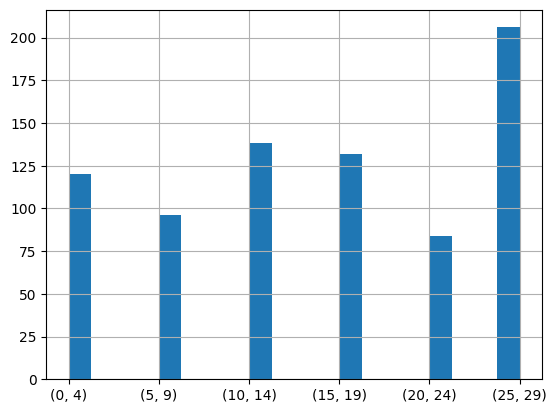

In [8]:
df["RANGE"].hist(bins=20)

([<matplotlib.axis.XTick at 0x1d829c83500>,
 [Text(0.30000000000000004, 0, '(0, 4)'),
  Text(1.3, 0, '(5, 9)'),
  Text(2.3, 0, '(10, 14)'),
  Text(3.3, 0, '(15, 19)'),
  Text(4.3, 0, '(20, 24)'),
  Text(5.3, 0, '(25, 29)')])

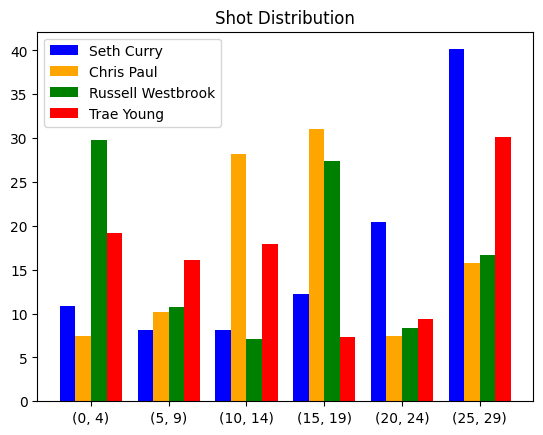

In [128]:
XRange = np.arange(6)

for i, Player in enumerate(Players):
    data = dict(df[df["SHOOTER"] == Player]["RANGE"].value_counts(sort=False) / len(df[df["SHOOTER"] == Player]) * 100)
    plt.bar((XRange + i * width), list(data.values()), width, color=Colors[i], label = Player)
    
plt.title("Shot Distribution")
plt.legend()
plt.xticks(XRange+1.5*width, list(data.keys()))

Each of the four shooters present a somewhat different style. Seth Curry specializes in long range shots, with most of his attempts being at 20 plus feet. The attempts are roughly proportional to the distance away from the basket. Chris Paul mainly shoots from mid-range, in between the paint and the three point line, but doesn't take incredibly deep midrange shots. There is a spike at 25-29 feet, but there are roughly as many shots at less than 10 feet and more than 19 feet. Russell Westbrook specializes in close and mid-range shots, with a spattering of threes. Trae Young spreads his shots out, with significant amounts of close, mid-range, and long range shots.

This collection of 4 players should provide many opportunities to compare and contrast their statistics. 

In [17]:
df["DEFENDER"].unique()

array(['Chris Paul', 'Trae Young', 'Russell Westbrook', 'Seth Curry'],
      dtype=object)

In [18]:
df["DEFENDER"].value_counts()

DEFENDER
Russell Westbrook    232
Chris Paul           197
Seth Curry           191
Trae Young           156
Name: count, dtype: int64

In [19]:
df["SCORE"].unique()

array(['MADE', 'MISSED'], dtype=object)

([<matplotlib.axis.XTick at 0x1d82c5044d0>,
 [Text(0.30000000000000004, 0, 'MADE'), Text(1.3, 0, 'MISSED')])

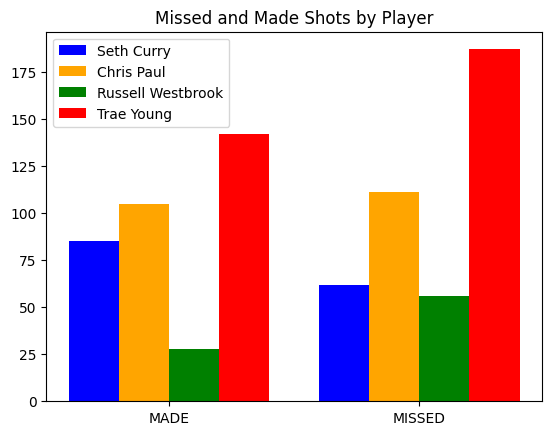

In [134]:
XRange = np.arange(2)
for i, Player in enumerate(Players):
    data = dict(df[df["SHOOTER"] == Player]["SCORE"].value_counts(sort=False))
    plt.bar(XRange + i * width, list(data.values()),width,color=Colors[i], label=Player)

plt.title("Missed and Made Shots by Player")
plt.legend()
plt.xticks(XRange+1.5*width, list(data.keys()))

This ends the preliminary data analysis. Now, I'll be looking at accuracy from the corner three spot, accuracy from three, mid-range and from up close. Then I will look at how well each person defended against shots.

As mentioned previously, corner threes are from 22 feet above and below the basket and 14 feet across as can be seen on this diagram on the NBA's website:

*https://ak-static.cms.nba.com/wp-content/uploads/sites/4/2019/02/NBA-Court-Dimensions-.png*

I will be selecting the shots where the absolute value of X is 22 or more feet, and Y is less than or equal to 14.

Accuracy for 3 will be divided into corner and arc 3's. Corner threes are from the corner, that is in between that line at 22 feet from the basket and the edge of the court. Arc 3's are the three's which are behind the curved portion of the three point line. This shots are all taken from 23 feet and 9 inches from the basket or further (this is 28 feet from the origin).

Mid-range is outside of the paint but encompassed by the 3 point line. The paint is a rectangle with dimensions: 12 by 19 feet. An easy solution will be to use the information from the shots up close and three to figure out mid-range accuracy.

Close range shots are those within the paint mentioned before.

Later on the percentages for each shot type will be graphed to show the efficacy of each shooter.

In [24]:
Corner3df = df[(abs(df.X) >= 22.0) & (df.Y <= 14)]
Corner3df.describe()

,INDEX,X,Y
count,54.000000,54.000000,54.000000
mean,486.370370,-4.515984,9.894997
std,255.485058,23.637168,2.161070
min,70.000000,-24.856870,5.441226
25%,320.500000,-24.232052,8.032838
50%,650.500000,-22.960338,10.255225
75%,703.500000,23.952742,11.731072
max,767.000000,23.952742,13.280662


In [25]:
Corner3df.head()

,INDEX,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
70,70,Seth Curry,-22.018244,12.370524,"(20, 24)",Trae Young,MADE
91,91,Seth Curry,-24.232052,5.829153,"(25, 29)",Russell Westbrook,MADE
97,97,Seth Curry,23.952742,10.040589,"(25, 29)",Chris Paul,MADE
101,101,Seth Curry,23.952742,10.814010,"(25, 29)",Trae Young,MADE
104,104,Seth Curry,23.952742,11.105474,"(25, 29)",Trae Young,MADE


In [26]:
Corner3df['SCORE'].value_counts()

SCORE
MISSED    28
MADE      26
Name: count, dtype: int64

In [27]:
SCCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Seth Curry']

SCCorner3percent = len(SCCorner3[SCCorner3["SCORE"] == "MADE"]) / len(SCCorner3["SCORE"]) * 100

print(len(SCCorner3["SCORE"]))
print(len(SCCorner3["SCORE"]) / len(df[df.SHOOTER == "Seth Curry"]) * 100)
SCCorner3percent

13
8.843537414965986


76.92307692307693

In [28]:
CPCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Chris Paul']

CPCorner3percent = len(CPCorner3[CPCorner3["SCORE"] == "MADE"]) / len(CPCorner3["SCORE"]) * 100

print(len(CPCorner3["SCORE"]))
print(len(CPCorner3["SCORE"]) / len(df[df.SHOOTER == "Chris Paul"]) * 100)
CPCorner3percent

8
3.7037037037037033


25.0

In [29]:
RWCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Russell Westbrook']

RWCorner3percent = len(RWCorner3[RWCorner3["SCORE"] == "MADE"]) / len(RWCorner3["SCORE"]) * 100

print(len(RWCorner3["SCORE"]))
print(len(RWCorner3["SCORE"]) / len(df[df.SHOOTER == "Russell Westbrook"]) * 100)
RWCorner3percent

4
4.761904761904762


25.0

In [30]:
TYCorner3 = Corner3df[Corner3df["SHOOTER"] == 'Trae Young']

TYCorner3percent = len(TYCorner3[TYCorner3["SCORE"] == "MADE"]) / len(TYCorner3["SCORE"]) * 100

print(len(TYCorner3["SCORE"]))
print(len(TYCorner3["SCORE"]) / len(df[df.SHOOTER == "Trae Young"]) * 100)
TYCorner3percent

29
8.814589665653495


44.827586206896555

We can see that corner threes are around 9% of the shots Seth Curry and Trae Young take, and they make them well. On the other hand, Westbrook and Paul don't take many at around 3-5% of their shots, and they do not make them often. I would expect Seth Curry's percentage to go down as he takes shots since 77% is unsustainable for volume shooters. 

It seems we can peg Seth Curry and Trae Young as 3 point specialists but we won't know for certain until analyzing the more popular 3 point shooting from the arc. 

I will be using the distance formula to definitively find all of the shots behind the three point line, but we need to get rid of the corner 3 shots. This means Y must be more than 14 and we need to use the distance formula to find the exact distance from the origin.


In [31]:
df[df["RANGE"] == "(25, 29)"].describe()

,INDEX,X,Y
count,206.000000,206.000000,206.000000
mean,469.305825,1.313896,22.440881
std,265.783588,18.801441,8.332400
min,88.000000,-24.856870,5.441226
25%,139.250000,-17.111975,15.854462
50%,442.500000,1.714225,24.114010
75%,723.750000,21.475274,30.330252
max,775.000000,24.767551,33.853913


In [32]:
df[df["RANGE"] == "(20, 24)"].describe()

,INDEX,X,Y
count,84.000000,84.000000,84.000000
mean,366.630952,0.363457,19.407309
std,253.838284,16.365375,6.594484
min,58.000000,-23.741319,6.396797
25%,78.750000,-16.849759,13.640112
50%,324.500000,1.801137,20.957780
75%,655.250000,16.421417,24.501316
max,676.000000,23.634205,28.730485


In [33]:
df["DISTANCE"] = np.sqrt(pow(df['X'],2) + pow(df['Y'],2))
df["DISTANCE"].describe()

count    776.000000
mean      19.876875
std        8.577239
min        5.020788
25%       12.587478
50%       19.983144
75%       27.278761
max       33.915899
Name: DISTANCE, dtype: float64

In [34]:
Arc3df = df[(df["DISTANCE"] >= 28) & (df.Y > 14)]
Arc3df.describe()

,INDEX,X,Y,DISTANCE
count,171.000000,171.000000,171.000000,171.000000
mean,458.257310,2.417690,25.963646,31.276768
std,264.076578,16.452276,5.649705,1.600585
min,67.000000,-24.677397,14.798480,28.061646
25%,139.500000,-12.044672,21.329076,30.101895
50%,437.000000,2.292376,27.660323,31.446080
75%,722.500000,19.890640,30.635445,32.589984
max,775.000000,24.767551,33.853913,33.915899


In [35]:
Arc3df['SCORE'].value_counts()

SCORE
MISSED    113
MADE       58
Name: count, dtype: int64

In [36]:
SCArc3 = Arc3df[Arc3df["SHOOTER"] == 'Seth Curry']

SCArc3percent = len(SCArc3[SCArc3["SCORE"] == "MADE"]) / len(SCArc3["SCORE"]) * 100

print(len(SCArc3["SCORE"]))
print(len(SCArc3["SCORE"]) / len(df[df.SHOOTER == "Seth Curry"]) * 100)
SCArc3percent

49
33.33333333333333


40.816326530612244

In [37]:
CPArc3 = Arc3df[Arc3df["SHOOTER"] == 'Chris Paul']

CPArc3percent = len(CPArc3[CPArc3["SCORE"] == "MADE"]) / len(CPArc3["SCORE"]) * 100

print(len(CPArc3["SCORE"]))
print(len(CPArc3["SCORE"]) / len(df[df.SHOOTER == "Chris Paul"]) * 100)
CPArc3percent

32
14.814814814814813


46.875

In [38]:
RWArc3 = Arc3df[Arc3df["SHOOTER"] == 'Russell Westbrook']

RWArc3percent = len(RWArc3[RWArc3["SCORE"] == "MADE"]) / len(RWArc3["SCORE"]) * 100

print(len(RWArc3["SCORE"]))
print(len(RWArc3["SCORE"]) / len(df[df.SHOOTER == "Russell Westbrook"]) * 100)
RWArc3percent

13
15.476190476190476


23.076923076923077

In [39]:
TYArc3 = Arc3df[Arc3df["SHOOTER"] == 'Trae Young']

TYArc3percent = len(TYArc3[TYArc3["SCORE"] == "MADE"]) / len(TYArc3["SCORE"]) * 100

print(len(TYArc3["SCORE"]))
print(len(TYArc3["SCORE"]) / len(df[df.SHOOTER == "Trae Young"]) * 100)
TYArc3percent

77
23.404255319148938


25.97402597402597

We can see a continuation of previously established trends with Seth Curry taking a lot of threes from the arc (33% of his total), and shooting well from there: 40.8%. 40% from three is generally considered good.

We also see Trae Young takes plenty of threes from the arc, just like his high percentage of corner 3's, but this time his field goal percentage is fairly poor.

Russell Westbrook follows the same trend as before: low three point field goal percentage with relatively few attempts. 

Chris Paul sort of follows the trend, as he attempts relatively few threes (15% of his total shots), but shoots them well, which is likely because of the fact that he only took 32 of them.

This confirms that Seth Curry is a 3 point specialist but Trae Young seems more like a volume shooter. His 3 point percentage is somewhat poor but he still takes quite a few. Chris Paul and Westbrook are a bit more difficult to peg. They are likely more close range shooters, though it is important to note Chris Paul's shooting percentage from three here.

The next step is to look at close range scoring, or scoring in the paint. Consulting the diagram again, the paint is 19 feet long by 16 feet wide so we will look at Y less than or equal to 19, and the absolute value of X being 8 or less.

In [40]:
Closedf = df[(abs(df.X) <= 8) & (df.Y <= 19)]
Closedf.describe()

,INDEX,X,Y,DISTANCE
count,271.000000,271.000000,271.000000,271.000000
mean,358.147601,0.219244,10.226405,10.955219
std,185.652304,3.927036,4.290056,4.287167
min,0.000000,-7.970607,5.008911,5.020788
25%,191.500000,-2.519773,6.673493,7.090837
50%,400.000000,0.365771,8.471616,10.200727
75%,512.000000,2.898745,13.401733,13.609687
max,621.000000,7.925733,18.965952,18.965960


In [41]:
SCClose = Closedf[Closedf["SHOOTER"] == 'Seth Curry']

SCClosepercent = len(SCClose[SCClose["SCORE"] == "MADE"]) / len(SCClose["SCORE"]) * 100

print(len(SCClose["SCORE"]))
print(len(SCClose["SCORE"]) / len(df[df.SHOOTER == "Seth Curry"]) * 100)
SCClosepercent

31
21.08843537414966


67.74193548387096

In [42]:
CPClose = Closedf[Closedf["SHOOTER"] == 'Chris Paul']

CPClosepercent = len(CPClose[CPClose["SCORE"] == "MADE"]) / len(CPClose["SCORE"]) * 100

print(len(CPClose["SCORE"]))
print(len(CPClose["SCORE"]) / len(df[df.SHOOTER == "Chris Paul"]) * 100)
CPClosepercent

68
31.48148148148148


60.29411764705882

In [43]:
RWClose = Closedf[Closedf["SHOOTER"] == 'Russell Westbrook']

RWClosepercent = len(RWClose[RWClose["SCORE"] == "MADE"]) / len(RWClose["SCORE"]) * 100

print(len(RWClose["SCORE"]))
print(len(RWClose["SCORE"]) / len(df[df.SHOOTER == "Russell Westbrook"]) * 100)
RWClosepercent

39
46.42857142857143


35.8974358974359

In [44]:
TYClose = Closedf[Closedf["SHOOTER"] == 'Trae Young']

TYClosepercent = len(TYClose[TYClose["SCORE"] == "MADE"]) / len(TYClose["SCORE"]) * 100

print(len(TYClose["SCORE"]))
print(len(TYClose["SCORE"]) / len(df[df.SHOOTER == "Trae Young"]) * 100)
TYClosepercent

133
40.42553191489361


52.63157894736842

We can see that Seth Curry has the lowest proportion of shots at close range, with Russell Westbrook and Trae Young having a high porportion of close range shots. This makes sense for Curry and Westbrook since it was established that Curry seemed to specialize in three pointers, and Westbrook avoided them. Chris Paul falls between these two groups. 

Based on the field goal percentage, we can see that although Chris Paul and Seth Curry take fewer shots than Young and Wetbrook they make them at a higher rate, likely because they choose their shots more caerfully (as a side note, it seems like Paul chooses his shots carefully overall from the percentages seen).

Westbrook goes for close range shots a lot, but has a poor shooting percentage for them. Everyone else actually has at least a decent percentage for them if not a good percentage.

This helps form opinions on Westbrook and Paul, while confirming what I said about Young. Trae Young is definitely a volume shooter, who takes many shots, from a variety of places but whose field goal percentage would suffer. On the other hand, Chris Paul is more conservative with his shots and seems to take better shots than Westbrook and Young (I make this assumption because he shoots less and is more accurate). Chris Paul also likes to take shots from all across the field, but this will be confirmed by the final analysis: the mid-range.

The mid-range is between the 3 point regions and close range, which is a complex boundary. The easiest way, and the reason I wanted to do this last, is to simply subtract all of the other ranges.

In [45]:
IndicesToRemove = list(Corner3df.index) + list(Arc3df.index) + list(Closedf.index)
Midrangedf = df.drop(IndicesToRemove)

In [46]:
print(len(df))
print(len(Corner3df) + len(Arc3df) + len(Closedf) + len(Midrangedf))

776
776


In [47]:
Midrangedf.describe()

,INDEX,X,Y,DISTANCE
count,280.000000,280.000000,280.000000,280.000000
mean,353.628571,0.546194,15.017884,20.389792
std,210.659141,13.098138,6.295466,4.539274
min,28.000000,-21.739994,5.026200,9.640798
25%,213.750000,-11.978224,9.441805,16.714738
50%,300.500000,0.633890,14.267021,21.047164
75%,588.500000,12.251378,20.901120,23.496335
max,694.000000,23.952742,27.879461,27.906710


In [48]:
SCMidrange = Midrangedf[Midrangedf["SHOOTER"] == 'Seth Curry']

SCMidrangepercent = len(SCMidrange[SCMidrange["SCORE"] == "MADE"]) / len(SCMidrange["SCORE"]) * 100

print(len(SCMidrange["SCORE"]))
print(len(SCMidrange["SCORE"]) / len(df[df.SHOOTER == "Seth Curry"]) * 100)
SCMidrangepercent

54
36.734693877551024


62.96296296296296

In [49]:
CPMidrange = Midrangedf[Midrangedf["SHOOTER"] == 'Chris Paul']

CPMidrangepercent = len(CPMidrange[CPMidrange["SCORE"] == "MADE"]) / len(CPMidrange["SCORE"]) * 100

print(len(CPMidrange["SCORE"]))
print(len(CPMidrange["SCORE"]) / len(df[df.SHOOTER == "Chris Paul"]) * 100)
CPMidrangepercent

108
50.0


43.51851851851852

In [50]:
RWMidrange = Midrangedf[Midrangedf["SHOOTER"] == 'Russell Westbrook']

RWMidrangepercent = len(RWMidrange[RWMidrange["SCORE"] == "MADE"]) / len(RWMidrange["SCORE"]) * 100

print(len(RWMidrange["SCORE"]))
print(len(RWMidrange["SCORE"]) / len(df[df.SHOOTER == "Russell Westbrook"]) * 100)
RWMidrangepercent

28
33.33333333333333


35.714285714285715

In [51]:
TYMidrange = Midrangedf[Midrangedf["SHOOTER"] == 'Trae Young']

TYMidrangepercent = len(TYMidrange[TYMidrange["SCORE"] == "MADE"]) / len(TYMidrange["SCORE"]) * 100

print(len(TYMidrange["SCORE"]))
print(len(TYMidrange["SCORE"]) / len(df[df.SHOOTER == "Trae Young"]) * 100)
TYMidrangepercent

90
27.35562310030395


43.333333333333336

After two sanity checks: checking the stats to see if the X and Y values make sense for midrange, and making sure the number of rows of the subsets equals the dataframe as a whole, it seems that the shortcut worked.

Everybody but Westbrook shoots midrange shots well. They form a decent portion of each player's shot attempts, though they form a massive part of Chris Paul's shot attempts, and a relatively small amount of Trae Young's shots.

The midrange seems to be Chris Paul's favorite shot type, and both Curry and Westbrook's second favorite shot. Trae Young seems to prefer 3 point shots and close range shots, although he seems to spread his shot attempts fairly evenly across close, mid and long range. Trae Young seems to prefer close and long range shots to them.

With all of this in mind, we can finalize what type of basketball player each person is. 

* **Seth Curry**: 3 point specialist who prefers to take long range shots with high efficiency.
* **Chris Paul**: A mid-range shooter who picks his shots carefully and likely doesn't take many shots a game, relative to someone like Trae Young for example.
* **Russell Westbrook**: A volume shooter who prefers close range shots.
* **Trae Young**: A volume shooter who has no significant preference for his shots, though the most used shot is close range.

Before moving on to analyze defense a bit, I'll graph some of the data found.

In [94]:
SCPercents = [ SCClosepercent, SCMidrangepercent, SCCorner3percent, SCArc3percent]
CPPercents = [ CPClosepercent, CPMidrangepercent, CPCorner3percent, CPArc3percent]
RWPercents =  [RWClosepercent, RWMidrangepercent,RWCorner3percent, RWArc3percent]
TYPercents = [ TYClosepercent, TYMidrangepercent, TYCorner3percent, TYArc3percent]

SCAttempts = [len(SCClose["SCORE"]),len(SCMidrange["SCORE"]), len(SCCorner3["SCORE"]),len(SCArc3["SCORE"])]
CPAttempts = [len(CPClose["SCORE"]),len(CPMidrange["SCORE"]),len(CPCorner3["SCORE"]),len(CPArc3["SCORE"])]
RWAttempts = [len(RWClose["SCORE"]),len(RWMidrange["SCORE"]),len(RWCorner3["SCORE"]),len(RWArc3["SCORE"])]
TYAttempts = [len(TYClose["SCORE"]),len(TYMidrange["SCORE"]),len(TYCorner3["SCORE"]),len(TYArc3["SCORE"])]

XAxisLabels = ["Close", "Midrange", "Corner 3", "Arc 3"]

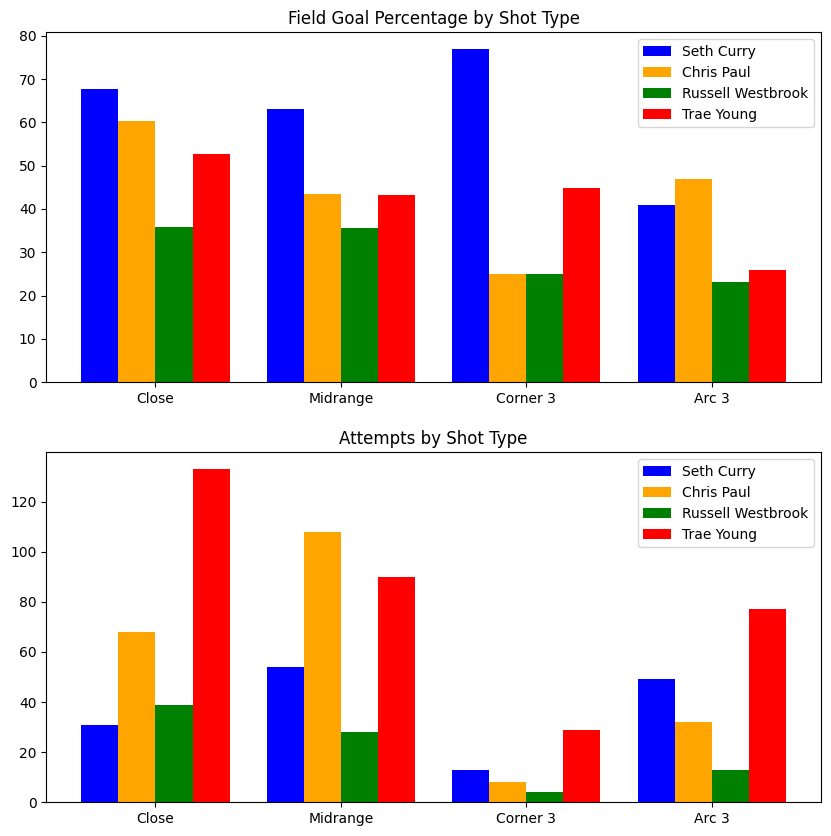

In [95]:
fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols=1)
multiplebars = np.arange(4)
fig.set_figwidth(10)
fig.set_figheight(10)
ax1.set_xticks(multiplebars + 1.5 * width, XAxisLabels)
ax1.bar(multiplebars, SCPercents, width, color='b', label='Seth Curry')
ax1.bar(multiplebars + width, CPPercents, width, color='orange', label='Chris Paul')
ax1.bar(multiplebars + 2 * width, RWPercents, width, color='g', label='Russell Westbrook')
ax1.bar(multiplebars + 3 * width, TYPercents, width, color='r', label='Trae Young')
ax1.set_title("Field Goal Percentage by Shot Type")
ax1.legend()

ax2.set_xticks(multiplebars + 1.5 * width, XAxisLabels)
ax2.bar(multiplebars, SCAttempts, width, color='b', label='Seth Curry')
ax2.bar(multiplebars + width, CPAttempts, width, color='orange', label='Chris Paul')
ax2.bar(multiplebars + 2 * width, RWAttempts, width, color='g', label='Russell Westbrook')
ax2.bar(multiplebars + 3 * width, TYAttempts, width, color='r', label='Trae Young')
ax2.set_title("Attempts by Shot Type")
ax2.legend()


<Axes: >

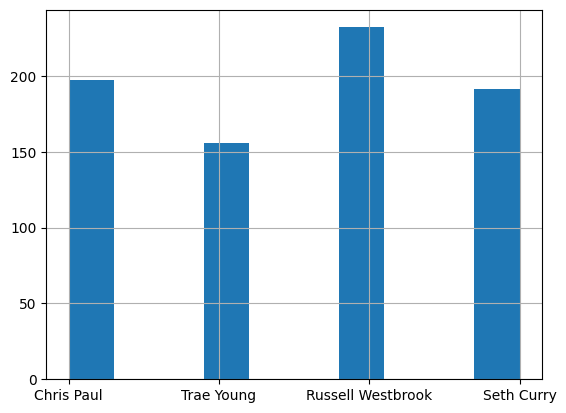

In [100]:
df["DEFENDER"].hist()

In [98]:
SCDefenderdf= df[df["DEFENDER"] == "Seth Curry"]
CPDefenderdf= df[df["DEFENDER"] == "Chris Paul"]
RWDefenderdf= df[df["DEFENDER"] == "Russell Westbrook"]
TYDefenderdf= df[df["DEFENDER"] == "Trae Young"]